<a href="https://colab.research.google.com/github/lemacdonald/CoordinateNetworksExercise/blob/main/CoordinateNetworkExercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Maths of AI Project: Coordinate networks and their peculiarities
## Lachlan MacDonald, with edits by Lewis Mitchell 

This project starts with the following image:

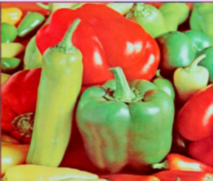

The aim of the project is to train a neural network to encode the image. In particular, you're going to train a model to predict the colour of each pixel, based on its position. The key task for you is going to be to search for a mapping (i.e., a function) that embeds the image in a higher dimension, such that the network encodes the image well.

This is an open research problem being worked on by the team at AIML! So we don't expect you to "solve" it. At the end of the project we want you to submit 2 things:
1. A short written report (a few pages) describing your final method clearly, and what the results were;
2. A 5-minute informal talk to the class in Week 13.

The goal of these items is to describe:
1. what you tried, and **how** you went about it;
2. what you found through your experimentation (what worked best), and most importantly;
3. **why** you think the mapping you ended up using worked well (or not).

We will also hold a competition (because machine learners love a good competition): to reproduce the original image above as closely as possible, using any ML approach that is trained on the training set below. I'll give a prize for the best submission, and nobody who makes a reasonable attempt will get a bad mark for this component of the grade.

There are many ways to approach this problem. You can brute-force a search through a set of functions and parameters. You can look into the literature on coordinate networks. You can try to derive a theory or an algorithm to search for good candidates. You can email some people from AIML and ask what they think. You can *even* define what "works well" means here -- different images with other types of features to the one above might lend themselves to different types of networks and embeddings.

All approaches are valid. Just explain to us the **what**, **why**, and **how** of your process in your final talk.

The rest of this notebook steps through an example, and then gives you some starting directions.

First, import the required packages.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from tqdm import tqdm

device = "cuda:0"

Now, convert the png image into two datasets: a training set (consisting of pixels whose coordinate sum is even) and a test set (consisting of pixels whose coordinate sum is odd).

In [2]:
# convert image to tensor
img = Image.open('peppersddown.png')
img = np.array(img)[:,:,:3]
total_targets = torch.as_tensor(img, dtype=torch.float32)/256.0

w = img.shape[0] # img width
h = img.shape[1] # img height

# create coordinate datasets
x = torch.linspace(0, (w-1)/w, w) # x coordinate
y = torch.linspace(0, (h-1)/h, h) # y coordinate
total_data = torch.stack(torch.meshgrid(x,y)).permute(1,2,0) # tensor of (x,y) coordinates
# now, total_data[i,j] is the (i,j)^th coordinate corresponding to the pixel value total_target[i,j]

# next, we split into train and test sets
train_data = total_data[(w*total_data[:,:,0] + h*total_data[:,:,1])%2 == 0]
train_targets = total_targets[(w*total_data[:,:,0] + h*total_data[:,:,1])%2 == 0]

test_data = total_data[(w*total_data[:,:,0] + h*total_data[:,:,1])%2 == 1]
test_targets = total_targets[(w*total_data[:,:,0] + h*total_data[:,:,1])%2 == 1]

/Users/lewis_math/opt/anaconda3/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1646755922314/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Now set up and initialise the network:

In [3]:
width = 100

# network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, width)
        self.fc2 = nn.Linear(width, width)
        self.fc3 = nn.Linear(width, width)
        self.fc4 = nn.Linear(width, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

net = Net()

Finally, train the network on the training set. We use the square loss with full-batch gradient descent, and store the loss at each epoch to plot later.

100%|██████████| 1000/1000 [01:29<00:00, 11.14it/s]


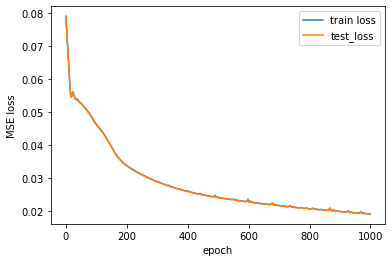

In [4]:
# optimiser
optimizer = optim.Adam(net.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=1e-8)
criterion = nn.MSELoss()

# training loop
epoch = 1000
x = np.arange(epoch)
y_train = np.zeros(epoch)
y_test = np.zeros(epoch)

for i in tqdm(range(epoch)):
    with torch.no_grad():
        output_test = net(test_data)
        loss_test = criterion(output_test, test_targets)
        y_test[i] = loss_test

    optimizer.zero_grad()
    output = net(train_data)
    loss = criterion(output, train_targets)
    y_train[i] = loss
    loss.backward()
    optimizer.step()

plt.plot(x,y_train, label="train loss")
plt.plot(x,y_test, label="test_loss")
plt.legend(loc="upper right")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.show()

The train and test curves look pretty much identical - our network generalises well!  Finally, let's see how well our network reproduces the image visually (you can look at the saved image by clicking on the folder icon on the left hand side of colab).

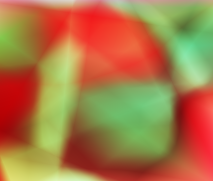

In [5]:
with torch.no_grad():
    output = net(total_data).cpu().numpy()
    outputrescale = (output*256).astype(np.uint8)
    data = Image.fromarray(outputrescale)
#     data.save('reprod.png')

data

Doesn't look great.  We could improve this by adding more layers and training for longer (give this a go if you like).  Instead, we'll be a bit cleverer.  We will embed our coordinates in a higher dimensional space using *positional encoding*.  With the extra "elbow room" afforded by the higher dimensionality, our network will be able to better fit the detail of the image without needing additional capacity.

One such higher-dimensional embedding obtained through positional encoding works much better:

![reprod_emb.png](reprod_emb.png)


Your project centres around the very next code cell: finding a higher-dimensional embedding for the training and testing data.

Here is a very simple idea for this embedding, to get you started. Let's embed our 2-d data into a 4-d space, by naively taking $\sin(\pi x)$ and $\cos(\pi x)$ of all $x$-components, and doing the same for the $y$-components:

In [6]:
def sin_cos_embedding(x):
    emb = torch.zeros((x.shape[0],4))
    emb[:,0] = torch.sin(np.pi*x[:,0])
    emb[:,1] = torch.cos(np.pi*x[:,0])
    emb[:,2] = torch.sin(np.pi*x[:,1])
    emb[:,3] = torch.cos(np.pi*x[:,1])
    return emb

# embed the data
train_data_emb = sin_cos_embedding(train_data)
test_data_emb = sin_cos_embedding(test_data)
total_data_emb = sin_cos_embedding(total_data.flatten(0,1))

**Project aim**: We want you to modify the function above, to try and reproduce the original image as closely as possible with your network.


Now we need to modify our network to account for the higher dimensional inputs.

In [7]:
width = 100
embedding_dim = 4

# network
class Net_emb(nn.Module):
    def __init__(self):
        super(Net_emb, self).__init__()
        self.fc1 = nn.Linear(embedding_dim, width)
        self.fc2 = nn.Linear(width, width)
        self.fc3 = nn.Linear(width, width)
        self.fc4 = nn.Linear(width, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

net_emb = Net_emb()

Finally - let's train and see what happens.

100%|██████████| 1000/1000 [01:27<00:00, 11.43it/s]


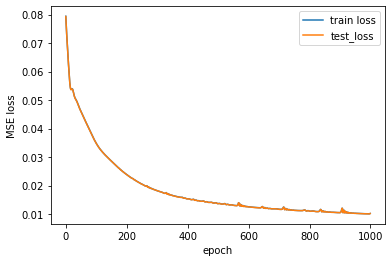

In [8]:
# optimiser
optimizer = optim.Adam(net_emb.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=1e-8)
criterion = nn.MSELoss()

# training loop
epoch = 1000
x = np.arange(epoch)
y_train = np.zeros(epoch)
y_test = np.zeros(epoch)

for i in tqdm(range(epoch)):
    with torch.no_grad():
        output_test = net_emb(test_data_emb)
        loss_test = criterion(output_test, test_targets)
        y_test[i] = loss_test

    optimizer.zero_grad()
    output = net_emb(train_data_emb)
    loss = criterion(output, train_targets)
    y_train[i] = loss
    loss.backward()
    optimizer.step()

plt.plot(x,y_train, label="train loss")
plt.plot(x,y_test, label="test_loss")
plt.legend(loc="upper right")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.show()

with torch.no_grad():
    output = net_emb(total_data_emb).reshape(w,h,3).cpu().numpy()
    outputrescale = (output*256).astype(np.uint8)
    data = Image.fromarray(outputrescale)
#     data.save('reprod_emb_sin_cos.png')

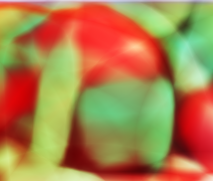

In [9]:
data

So our model with the sin-cos embedding performs slightly better than the original network at reproducing the original image... See if you can do better. Good luck! Make sure you *explain* what you did in your presentation, and give us your intuition for why you think it works well.

A hint: you are not the first person to look at this problem by any means. A bit of research on positional encodings will help you. In fact, I got the idea for my sin-cos embedding from a very famous paper called "Attention is all you need" by Vaswani et al. The encoding is not the focus of that paper, but it's still a decent place to start.


## Competition

OK, now for the competition. The competition is simply to reproduce the original image as well as possible, that is, to have the lowest mean-square-error loss between `output_test` and `test_targets` above. You can do this in any way you want (short of cheating): clever embeddings, more complex network architecture, [random seed hacking](https://www.reddit.com/r/reinforcementlearning/comments/i3dwoz/just_try_a_different_random_seed/)... go nuts.

Rules:
1. You have to submit your notebook with your entry. I will run it as-is in colab, and your entry will be the output of the `loss_test = criterion(output_test, test_targets)` line at the end of execution. Set your random seeds!
2. Your notebook has to finish executing (i.e., preparing data, training your network) within 20 minutes.
3. You can't train on the test data. Obvs. 

Assessment:

Your grade will be proportional to a function of `loss_test`, which I will choose to provide a reasonable scale and discrimination. Nobody who submits will get less than 5 out of 10 for this component of the course. (And I won't necessarily scale so that the worst submission gets as low as 5 either.)

